# Binary Classifier
*By Joe Tungate*

In this notebook, a binary classifier is built using the Fuzzy Tensor Logic package ftlogic. The purpose of this task is to demonstrate how learning and reasoning operates under FTL.

In [1]:
import ftlogic.core as ftl
import ftlogic.fuzzyops as fops
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

## Data Processing
For this task, a synthetic dataset is made. The dataset consists of two one-thousand sample classes. The two classes are mostly linearly seperable.

In [18]:
samplesPerClass = 1000

xPos = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5], [0.5, 1]],
    size=samplesPerClass
)
xNeg = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5], [0.5, 1]],
    size=samplesPerClass
)

x = np.vstack((xNeg, xPos)).astype(np.float32)

y = np.vstack((np.zeros((samplesPerClass, 1), dtype="float32"),
np.ones((samplesPerClass, 1), dtype="float32")))

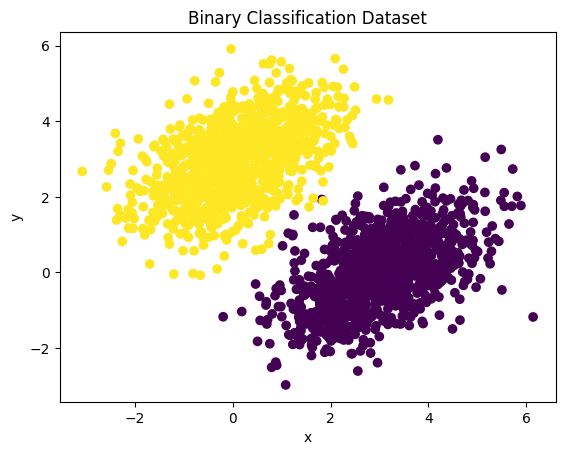

In [19]:
plt.scatter(x[:, 0], x[:, 1], c=y[:, 0])
plt.title("Binary Classification Dataset")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Defining the System

We now define the FTL system. Our signature will consists of a single predicate, Pos(x), whose value is one when x belongs to the positive class and zero when x belongs to the negative class. In the structure, Pos will be interpreted as a simple single-layer neural network.  

### Signature and Knowledge Base

In [20]:
sig = ftl.Signature(
    predicates={"Pos": 1}
)

In [21]:
kb = ftl.KnowledgeBase(
    signature=sig,
    formulas=[
        "Ax~P:Pos(x)",
        "Ax~N:!Pos(x)",
    ],
)

### Structure and Interpretation
We now map our symbols to actual tensors and functions.

In [22]:
Pos = keras.Sequential([
    keras.Input((2,)),
    keras.layers.Dense(1, activation="sigmoid")
])


In [23]:
struc = ftl.Structure(
    signature=sig,
    mappings={"Pos": Pos}
)

In [24]:
interp = ftl.Interpretation(
    structure=struc,
    domainAssignment={
        "P": xPos,
        "N": xNeg,
        "D": x}
)

### The Model

We now define and train our model. The model uses the StandardProductSet as its operatorSet. We train for 100 epochs using the Keras RMSprop optimiser with a learning rate of 0.1 

In [25]:
model = ftl.Model(
    knowledgeBase=kb,
    interpretation=interp,
    operatorSet=fops.standardProductSet
)

In [26]:
history = model.fit(
    100,
    keras.optimizers.RMSprop(learning_rate=0.1),
    fops.standardProductSet.universal,
    Pos.trainable_weights)

Training model for 100 epochs.
epoch 1 / 100. 
loss: [[0.66312337]], 
satisfaction: [[0.33687663]].
epoch 2 / 100. 
loss: [[0.4520771]], 
satisfaction: [[0.5479229]].
epoch 3 / 100. 
loss: [[0.29826498]], 
satisfaction: [[0.701735]].
epoch 4 / 100. 
loss: [[0.22438204]], 
satisfaction: [[0.77561796]].
epoch 5 / 100. 
loss: [[0.18476677]], 
satisfaction: [[0.81523323]].
epoch 6 / 100. 
loss: [[0.15969586]], 
satisfaction: [[0.84030414]].
epoch 7 / 100. 
loss: [[0.14240861]], 
satisfaction: [[0.8575914]].
epoch 8 / 100. 
loss: [[0.12961209]], 
satisfaction: [[0.8703879]].
epoch 9 / 100. 
loss: [[0.11967719]], 
satisfaction: [[0.8803228]].
epoch 10 / 100. 
loss: [[0.1116699]], 
satisfaction: [[0.8883301]].
epoch 11 / 100. 
loss: [[0.10504305]], 
satisfaction: [[0.89495695]].
epoch 12 / 100. 
loss: [[0.09944308]], 
satisfaction: [[0.9005569]].
epoch 13 / 100. 
loss: [[0.09463209]], 
satisfaction: [[0.9053679]].
epoch 14 / 100. 
loss: [[0.09044242]], 
satisfaction: [[0.9095576]].
epoch 15 /

### Results
We plot and inspect the loss and knowledge base satisfaction.

In [37]:
loss = [x.numpy()[0] for x in history['loss']]
satisfaction = [x.numpy()[0] for x in history['satisfaction']]
sat1 = [x.numpy()[0] for x in history['formula_satisfaction'][0]]
sat2 = [x.numpy()[0] for x in history['formula_satisfaction'][1]]

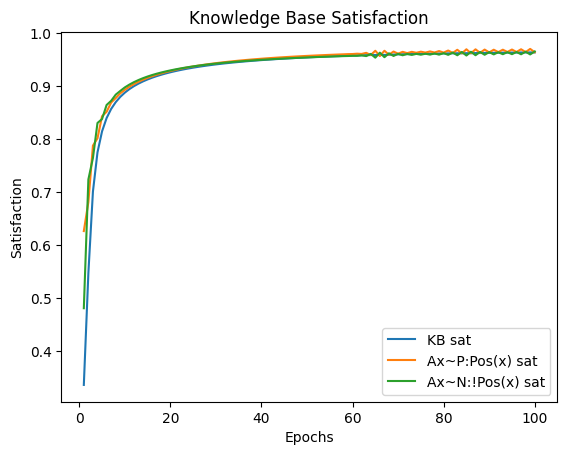

In [38]:
epochs = np.arange(1, 101)
plt.plot(epochs, satisfaction, label="KB sat")
plt.plot(epochs, sat1, label="Ax~P:Pos(x) sat")
plt.plot(epochs, sat2, label="Ax~N:!Pos(x) sat")
plt.xlabel("Epochs")
plt.ylabel("Satisfaction")
plt.title("Knowledge Base Satisfaction")
plt.legend()
plt.show()

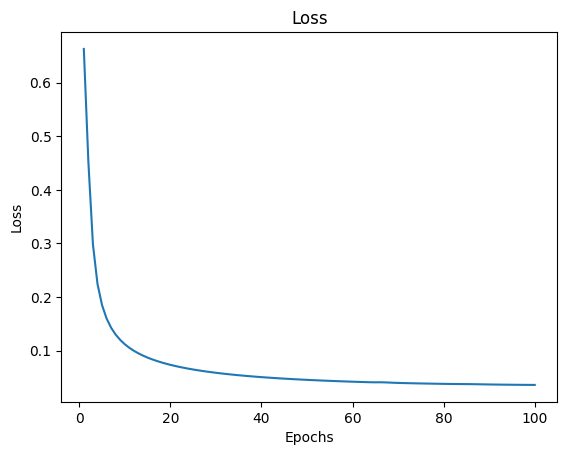

In [39]:
plt.plot(epochs, loss)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [40]:
print(f"Loss at epoch 100: {loss[-1]}")

Loss at epoch 100: [0.03574389]


In [41]:
print(f"kb satisfaction at epoch 100: {satisfaction[-1]}")

kb satisfaction at epoch 100: [0.9642561]


We graph the decision boundary to see what the agent actually learned.

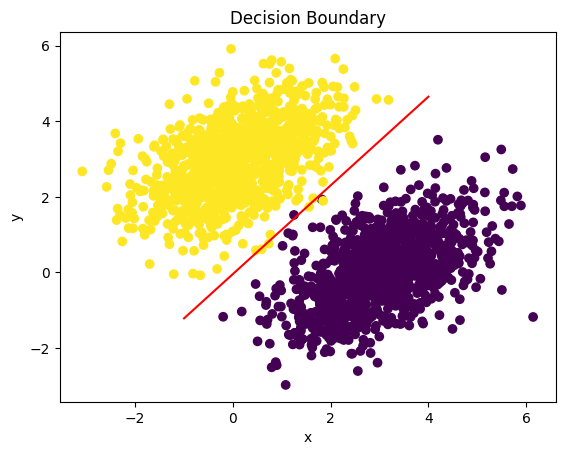

In [43]:
W = Pos.trainable_weights[0]
b = Pos.trainable_weights[1]
xaxis = np.linspace(-1, 4, 100)
yaxis = - W[0] / W[1] * xaxis + (0.5 - b) / W[1]
plt.scatter(x[:, 0], x[:, 1], c=y[:, 0])
plt.plot(xaxis, yaxis, "-r")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Decision Boundary")
plt.show()

Finally, we calculate the classification accuracy.

In [46]:
predictions = Pos.predict(x)
accmetric = keras.metrics.BinaryAccuracy(threshold=0.5)
accmetric.update_state(y, predictions)
accmetric.result()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.999>

### Query
After training the agent, it is possible to meaningfully query it.

In [51]:
model.query("Ex~P:!Pos(x)")

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00572463]], dtype=float32)>

Choosing a different operator set leads to different truth values.

In [48]:
model.operatorSet = fops.OperatorSet(
    fops.strongNegation,
    fops.tnormGodel,
    fops.tconormGodel,
    fops.sImplication(fops.tconormGodel),
    fops.universalAgg(fops.tnormGodel),
    fops.existentialAgg(fops.tconormGodel),
)

model.query("Ex~P:!Pos(x)")

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5841977], dtype=float32)>